## NWB-Datajoint tutorial

The goal of this tutorial is to demonstrate how to extract information from an NWB file and place it into our Datajoint database for analysis, in particular spike sorting. 

Let's start by importing the `nwb_datajoint` package, along with a few others. 

In [1]:
from pathlib import Path
import os
import numpy as np
import time

import nwb_datajoint as nd
import spiketoolkit as st
import pynwb

import warnings
warnings.simplefilter('ignore')

# Comment these if you have already set these environment variables
data_dir = Path('/stelmo/nwb') # CHANGE ME TO THE BASE DIRECTORY FOR DATA STORAGE ON YOUR SYSTEM
os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = 'TRUE'
os.environ['KACHERY_P2P_API_PORT'] = '14747'
os.environ['NWB_DATAJOINT_BASE_DIR'] = str(data_dir)
os.environ['KACHERY_STORAGE_DIR'] = str(data_dir / 'kachery-storage')
os.environ['SPIKE_SORTING_STORAGE_DIR'] = str(data_dir / 'spikesorting')

Connecting kyu@lmf-db.cin.ucsf.edu:3306


In [2]:
# We also import a bunch of tables so that we can call them easily
from nwb_datajoint.common import RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,\
                                 DataAcquisitionDevice, CameraDevice, Probe,\
                                 DIOEvents,\
                                 ElectrodeGroup, Electrode, Raw, SampleCount,\
                                 LFPSelection, LFP, LFPBandSelection, LFPBand,\
                                 SortGroup, SpikeSorting, SpikeSorter, SpikeSorterParameters, SpikeSortingWaveformParameters, SpikeSortingParameters, SpikeSortingMetrics, CuratedSpikeSorting,\
                                 FirFilter,\
                                 IntervalList, SortInterval,\
                                 Lab, LabMember, Institution,\
                                 BrainRegion,\
                                 SensorData,\
                                 Session, ExperimenterList,\
                                 Subject,\
                                 Task, TaskEpoch,\
                                 Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery

We assume that we have already converted a recording to the NWB format. For the purposes of this tutorial, we will use the `beans20190718.nwb` file. 

In [3]:
# Define the file name
nwb_file_name = 'beans20190718.nwb'
filename, file_extension = os.path.splitext(nwb_file_name)
# This is a copy of the original nwb file, except it doesn't contain the raw data (for storage reasons)
nwb_file_name2 = filename + '_' + file_extension

### Inserting data

As you may know, the NWB file contains a lot of information, such as information about the experimenter (e.g. who did the experiment, where was it done, etc); the animal's behavior (e.g. video recording of the animal's position in an environment during the experiment); the neural activity (extracellular recording of multiple brain areas) etc. We wish to enter this information into the tables of our Datajoint database so that we can easily access them later. If we have an NWB file that has been properly generated, this is straightforward: just run the `nd.insert_session` function, which will populate many of the tables automatically. Let's do this for our example NWB file.

In [6]:
nd.insert_sessions(nwb_file_name)

Creating a copy of NWB file beans20190718.nwb with link to raw ephys data: beans20190718_.nwb
Populate Session...
Institution...
Lab...
LabMember...
Subject...
DataAcquisitionDevice...
CameraDevice...
Inserted ['beans sleep camera', 'beans run camera']
Probe...
Skipping Apparatus for now...
IntervalList...
Populate ExperimenterList...
Populate ElectrodeGroup...
Populate Electrode...
Populate Raw...
Estimating sampling rate...
Estimated sampling rate: 20000.0
Importing raw data: Estimated sampling rate:	20000.0 Hz
                    Number of valid intervals:	5
Populate SampleCount...
Populate DIOEvants...
Populate SensorData
Populate TaskEpochs
Populate StateScriptFile
Populate VideoFile
RawPosition...
Processing raw position data. Estimated sampling rate: 30.0 Hz
Processing raw position data. Estimated sampling rate: 30.0 Hz
Processing raw position data. Estimated sampling rate: 30.0 Hz
Processing raw position data. Estimated sampling rate: 30.0 Hz


### Visualizing the database

Datajoint enables users to use Python to build and interact with a *relational database*, which is a fancy way of calling a set of tables that are related to one another in some way. The following diagram (called *entity relationship diagram*) shows all the tables in our database and their relationships.

Polygons refer to tables:
* Blue oval: tables whose entries are imported from external files (e.g. NWB file).
* Green rectangle: tables whose entries are entered manually.
* Red circle: tables whose entries are computed from entries of other tables.
* No shape: tables whose entries are part of the table upstream

Lines refer to *dependencies* between tables:
* Bold lines: downstream table inherits the primary key of upstream table as its primary key
* Solid lines: downstream table inherits the primary key of upstream table as part of its primary key
* Dashed lines: downstream table inherits the primary key of upstream table as non-primary key

Primary key: a set of attributes (i.e. column names) used to uniquely define an entry (i.e. a row)

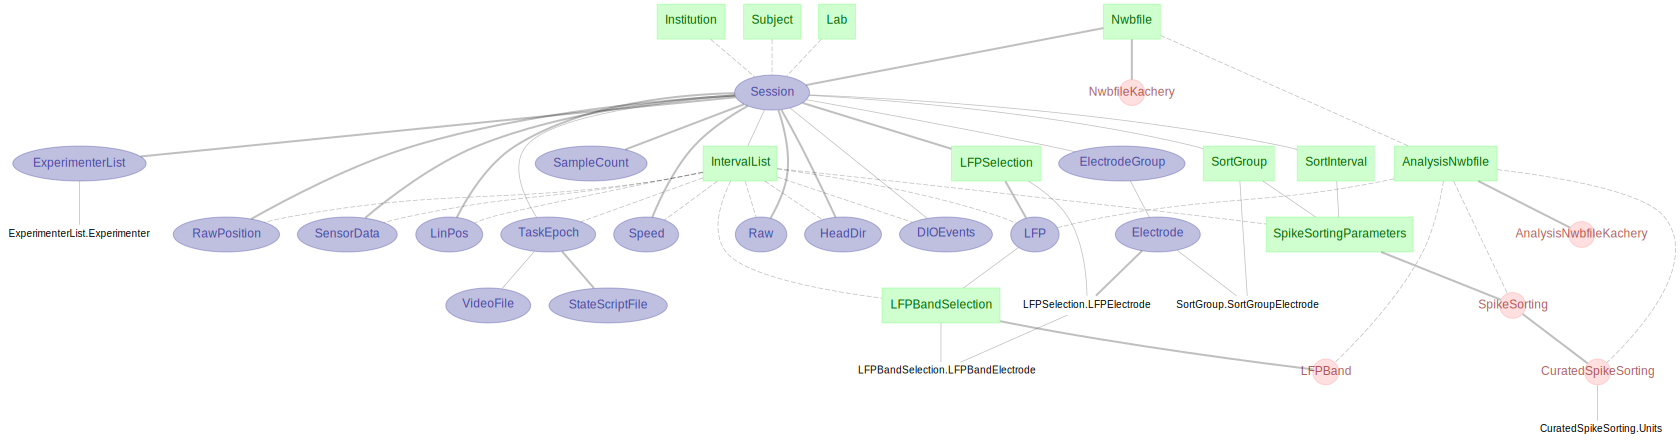

In [4]:
# Draw tables that are three levels below and one level above Session 
nd.dj.ERD(Session)-1+3

### Inspecting and querying data

To look at the tables, just call it (don't forget the `()` at the end, as tables are like Python classes). Let's try calling the `Lab` table.

In [5]:
Lab()

lab_name
Loren Frank


There is only one attribute (`lab_name`) and one entry (`Loren Frank`) in this table. Note that even though `Lab` is one of the tables that has to be manually entered (i.e. the green rectangles in our ERD), `nd.insert_sessions` populates it from the NWB file.

Let's look at a more interesting table: `Session`.

In [6]:
Session()

nwb_file_name the name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
despereaux20191125_.nwb,Despereaux,"University of California, San Francisco",Loren Frank,4,Sungod,2019-11-25 10:17:29,1970-01-01 00:00:00,Sungod control
Jaq20190826_.nwb,Jaq,"University of California, San Francisco",Loren Frank,jaq_01,Theta and gait,2019-08-26 16:53:47,1970-01-01 00:00:00,Theta and gait


This session has multiple attributes. The attributes that make up the primary key are shown in bold. In this case, there is only one attribute in the primary key: `nwb_file name`. Given that many downstream tables are connected to `Session` via bold lines, you can use this attribute to uniquely define data entries in many tables in our database.

To look at specific entries from a table, include the appropriate condition with the `&` operator. The condition must be in the form of a key-value pair, or a dictionary. As an example, let's view only the entry whose `nwb_file_name` is our example NWB file in `Session`:

In [7]:
Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name the name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning


Now let's go to a downstream table: `Raw`. This table is connected to `Session` table with a bold line, so it has the same primary key.

In [8]:
Raw & {'nwb_file_name':nwb_file_name2}

nwb_file_name the name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
beans20190718_.nwb,raw data valid times,d97e590f-4c09-470d-9a19-38d667b3c3da,20000.0,sample comment,Electrical series registered on electrode


`IntervalList` table is connected to `Session` table with a solid line, so it inherits `nwb_file_name` as one of the two attributes that make up the primary key. This means that you need to know both `nwb_file_name` and `interval_list_name` to uniquely identify an entry.

In [9]:
IntervalList & {'nwb_file_name':nwb_file_name2}

nwb_file_name the name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
beans20190718_.nwb,01_s1,=BLOB=
beans20190718_.nwb,02_r1,=BLOB=
beans20190718_.nwb,03_s2,=BLOB=
beans20190718_.nwb,04_r2,=BLOB=
beans20190718_.nwb,pos 0 valid times,=BLOB=
beans20190718_.nwb,pos 1 valid times,=BLOB=
beans20190718_.nwb,pos 2 valid times,=BLOB=
beans20190718_.nwb,pos 3 valid times,=BLOB=
beans20190718_.nwb,raw data valid times,=BLOB=


As you can see, some of the data is shown in the table (e.g. `interval_list_name`) while others are obscured (e.g. `valid_times` are shown as =BLOB=). To inspect the data, use the `fetch` (for getting multiple entries) or `fetch1` (for getting just one entry) methods. The following query returns `valid_times` of an interval list called `04_r2`.

In [10]:
(IntervalList & {'nwb_file_name':nwb_file_name2, 'interval_list_name':'04_r2'}).fetch1('valid_times')

array([[1.56349543e+09, 1.56349711e+09]])

Query supports many operations and conditions - just make sure the conditions are in the form of a dictionary. For example, `-` is like the set-theoretic complement. The following query returns all `interval_list_name` that is not `01_s1` or `04_r2`.

In [14]:
((IntervalList & {'nwb_file_name':nwb_file_name2}) - ({'interval_list_name':'01_s1'} and \
                                                      {'interval_list_name':'04_r2'})).fetch('interval_list_name')

array(['01_s1', '02_r1', '03_s2', 'pos 0 valid times',
       'pos 1 valid times', 'pos 2 valid times', 'pos 3 valid times',
       'raw data valid times'], dtype=object)

Another neat feature of Datajoint is that it automatically maintains the integrity of your data. For example, if we were to delete our entry in the `Session` table, the associated entries in all of the downstream tables (e.g. `Raw`, `IntervalList`, `ElectrodeGroup` to name a few) will also be deleted. That way, there is no 'orphan' data whose origin cannot be tracked.

### Spike sorting

Now that we know the structure of our database and how to insert, query, and inspect data in our database, let's turn our attention to spike sorting. In general, running spike sorting requires that we make a number of decisions about: 
1. which eletrodes to sort together (e.g. electrodes that form a tetrode should be sorted together, but tetrodes that are far apart need not be)
2. which the time interval to sort (e.g. there may a long period in the recording where nothing is happening, which we want to exclude)
3. which spike sorter to use (e.g. Mountainsort? Kilosort? IronClust?)
4. given choice of the spike sorter in 3, which parameter set to use

In our Datajoint framework, every that we do is an interaction with a table. This is true for spike sorting as well - i.e. we think of spike sorting as a process where we enter parameters of spike sorting (i.e. our decisions about the four questions above) into a table, and used that to populate another table that will hold the result of spike sorting. Under the hood, we use a number of packages such as `spikeinterface` and `labbox-ephys`. But the user need not know how to use them - they just have to interact with the table. 

Another advantage: there is a record of exactly which decisions you made. 

#### Define sort group
We start with the first question: which electrodes do we want to sort together? We first inspect the `Electrode` table.

In [9]:
Electrode & {'nwb_file_name': nwb_file_name2}

nwb_file_name the name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,bad_channel if electrode is 'good' or 'bad' as observed during recording,x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal -- current workaround
beans20190718_.nwb,0,0,128c-4s8mm6cm-20um-40um-sl,0,0,1,0,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,1,128c-4s8mm6cm-20um-40um-sl,0,1,1,1,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,3,128c-4s8mm6cm-20um-40um-sl,0,3,1,3,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,4,128c-4s8mm6cm-20um-40um-sl,0,4,1,4,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,5,128c-4s8mm6cm-20um-40um-sl,0,5,1,5,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,7,128c-4s8mm6cm-20um-40um-sl,0,7,1,7,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,8,128c-4s8mm6cm-20um-40um-sl,0,8,1,8,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,9,128c-4s8mm6cm-20um-40um-sl,0,9,1,9,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,11,128c-4s8mm6cm-20um-40um-sl,0,11,1,11,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
beans20190718_.nwb,0,12,128c-4s8mm6cm-20um-40um-sl,0,12,1,12,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


This recording was done with polymer probes. Here `electrode_group_name` refers to a probe. We can see that there were two probes, `0` and `1`.

In [16]:
# get unique probe id
np.unique(Electrode.fetch('electrode_group_name'))

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

Each probe has four shanks, as you can see:

In [17]:
# get unique shank id for the first probe
np.unique((Electrode & {'electrode_group_name': 0}).fetch('probe_shank'))

array([0, 1, 2, 3])

Our job is to identify the electrodes that we want to sort together, and add them as a sort group in the `SortGroup` table. One natural way to do this for probe recordings is to set each shank as a sort group. Use `set_group_by_shank` method for this:

In [19]:
SortGroup().set_group_by_shank(nwb_file_name2)

About to delete:
Nothing to delete


This generates 8 sort groups, one for each of the four shanks in the two probes.

In [20]:
SortGroup()

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
beans20190718_.nwb,0,-1
beans20190718_.nwb,1,-1
beans20190718_.nwb,2,-1
beans20190718_.nwb,3,-1
beans20190718_.nwb,4,-1
beans20190718_.nwb,5,-1
beans20190718_.nwb,6,-1
beans20190718_.nwb,7,-1
despereaux20191125_.nwb,0,-1
despereaux20191125_.nwb,1,-1


`SortGroup` has a *parts table* called `SortGroupElectrode` - think of this as child table that contains information auxiliary to the parent table. As you can see, it contains two extra attributes: `electrode_group_name` and `electrode_id`.

In [21]:
SortGroup.SortGroupElectrode()

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
beans20190718_.nwb,0,0,0
beans20190718_.nwb,0,0,1
beans20190718_.nwb,0,0,3
beans20190718_.nwb,0,0,4
beans20190718_.nwb,0,0,5
beans20190718_.nwb,0,0,7
beans20190718_.nwb,0,0,8
beans20190718_.nwb,0,0,9
beans20190718_.nwb,0,0,11
beans20190718_.nwb,0,0,12


What if you don't want to sort by shank? Maybe you want to select specific electrodes across shanks and sort them. To do so, you just have to manually `insert` a new entry into the `SortGroup` and `SortGroupElectrode` tables. 

In [23]:
# First we make a new entry in the SortGroup table, and give it sort_group_id of 8
SortGroup.insert1({'nwb_file_name': nwb_file_name2, 'sort_group_id': 8, 'sort_reference_electrode_id': -1})
# Next, we will associate with the sort group that we just created every fourth electrode of the first shank
SortGroup.SortGroupElectrode.insert([[nwb_file_name2, 8, 0, elec] for elec in range(0,32,4)])

Note that `insert` is a method, just like `fetch`. You can insert an entry in the form of a dictionary or a list in the order of the attributes. We can look at the new entries we just made.

In [46]:
sort_group_id = 8
SortGroup & {'nwb_file_name' : nwb_file_name2, 'sort_group_id' : sort_group_id}

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
beans20190718_.nwb,8,-1


In [47]:
SortGroup.SortGroupElectrode & {'nwb_file_name': nwb_file_name2, 'sort_group_id': sort_group_id}

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
beans20190718_.nwb,8,0,0
beans20190718_.nwb,8,0,4
beans20190718_.nwb,8,0,8
beans20190718_.nwb,8,0,12
beans20190718_.nwb,8,0,16
beans20190718_.nwb,8,0,20
beans20190718_.nwb,8,0,24
beans20190718_.nwb,8,0,28


#### Define sort interval
Next, we make a decision about the time interval for our spike sorting. Let's re-examine `IntervalList`.

In [32]:
IntervalList & {'nwb_file_name' : nwb_file_name2}

nwb_file_name the name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
beans20190718_.nwb,01_s1,=BLOB=
beans20190718_.nwb,02_r1,=BLOB=
beans20190718_.nwb,03_s2,=BLOB=
beans20190718_.nwb,04_r2,=BLOB=
beans20190718_.nwb,pos 0 valid times,=BLOB=
beans20190718_.nwb,pos 1 valid times,=BLOB=
beans20190718_.nwb,pos 2 valid times,=BLOB=
beans20190718_.nwb,pos 3 valid times,=BLOB=
beans20190718_.nwb,raw data valid times,=BLOB=


For our example, let's just decide the first 10 seconds of the first run interval (`02_r1`) as our sort interval. To do so, we first fetch `valid_times` of this interval, define our new sort interval, and add this to the `SortInterval` table.

In [39]:
interval_list_name = '02_r1'
interval = (IntervalList & {'nwb_file_name' : nwb_file_name2,
                            'interval_list_name' : interval_list_name}).fetch1('valid_times')
print(interval)

[[1.56349063e+09 1.56349340e+09]]


In [40]:
sort_interval = np.asarray([interval[0][0]+110, interval[0][0]+120])
print(sort_interval)

[1.56349074e+09 1.56349075e+09]


In [38]:
# Check out SortInterval
SortInterval & {'nwb_file_name' : nwb_file_name2}

nwb_file_name the name of the NWB file,sort_interval_name descriptive name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting


In [41]:
# Specify the required attributes
sort_interval_name = 'beans_02_r1_10s'
SortInterval.insert1({'nwb_file_name' : nwb_file_name2,
                      'sort_interval_name' : sort_interval_name,
                      'sort_interval' : sort_interval}, skip_duplicates=True)

In [42]:
# See results
SortInterval & {'nwb_file_name' : nwb_file_name2}

nwb_file_name the name of the NWB file,sort_interval_name descriptive name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting
beans20190718_.nwb,beans_02_r1_10s,=BLOB=


#### Define sorter
Next we decide which spike sorter to use. This boils down to looking at the `SpikeSorter` table and choosing the one we like. Initially, `SpikeSorter` may not be populated; in that case, we insert some sorters to it by checking which ones are available via `spikeinterface`, the package that we will be using implicitly for spike sorting.

In [36]:
SpikeSorter().insert_from_spikeinterface()

In [37]:
SpikeSorter()

sorter_name the name of the spike sorting algorithm
hdsort
herdingspikes
ironclust
kilosort
kilosort2
klusta
mountainsort4
spykingcircus
tridesclous
waveclus


In [44]:
sorter_name = 'mountainsort4'

For our example, we will be using `mountainsort4`.

#### Define sorter parameters
Once we have decided on a spike sorter, we have to set parameters. Some of these parameters are common to all sorters (e.g. frequency band to filter the raw data before sorting begins) but most are specific to the sorter that we chose. Again, we populate `SpikeSorterParameters` table with some default parameters for each sorter, and then we add our version as a new entry.

In [38]:
SpikeSorterParameters().insert_from_spikeinterface()

In [94]:
SpikeSorterParameters()

sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,parameter_dict dictionary of parameter names and values,frequency_min high pass filter value,frequency_max low pass filter value,filter_width the number of coefficients in the filter,filter_chunk_size the size of the chunk for the filtering
hdsort,default,=BLOB=,300,6000,1000,30000
herdingspikes,default,=BLOB=,300,6000,1000,30000
ironclust,default,=BLOB=,300,6000,1000,30000
kilosort,default,=BLOB=,300,6000,1000,30000
kilosort2,default,=BLOB=,300,6000,1000,30000
klusta,default,=BLOB=,300,6000,1000,30000
mountainsort4,default,=BLOB=,300,6000,1000,30000
spykingcircus,default,=BLOB=,300,6000,1000,30000
tridesclous,default,=BLOB=,300,6000,1000,30000
waveclus,default,=BLOB=,300,6000,1000,30000


Define a new set of spike sorter parameters from default and add to table.

In [45]:
# Let's look at the default params
ms4_default_params = (SpikeSorterParameters & {'sorter_name': sorter_name,
                                               'parameter_set_name' : 'default'}).fetch1()
print(ms4_default_params)

{'sorter_name': 'mountainsort4', 'parameter_set_name': 'default', 'parameter_dict': {'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'curation': False, 'num_workers': None, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'noise_overlap_threshold': 0.15}, 'frequency_min': 300, 'frequency_max': 6000, 'filter_width': 1000, 'filter_chunk_size': 30000}


In [53]:
# Change the default params
param_dict = ms4_default_params['parameter_dict']
param_dict['adjacency_radius'] = 0
param_dict['curation'] = False
# set num_workers to be the same number as the number of electrodes
param_dict['num_workers'] = len((SortGroup.SortGroupElectrode & {'sort_group_id':8}).fetch('electrode_id'))
param_dict['verbose'] = True
param_dict['clip_size'] = 40
param_dict['noise_overlap_threshold'] = 0

In [54]:
# Insert
parameter_set_name = 'test'
SpikeSorterParameters.insert1({'sorter_name' : sorter_name,
                               'parameter_set_name' : parameter_set_name,
                               'parameter_dict' : param_dict}, skip_duplicates = True)

In [55]:
# Check that insert was successful
SpikeSorterParameters & {'sorter_name' : sorter_name, 'parameter_set_name' : parameter_set_name}

sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,parameter_dict dictionary of parameter names and values,frequency_min high pass filter value,frequency_max low pass filter value,filter_width the number of coefficients in the filter,filter_chunk_size the size of the chunk for the filtering
mountainsort4,test,=BLOB=,300,6000,1000,30000


#### Set waveform and metric parameters

We're almost done. There are more parameters related to how we are going to compute the waveforms and the metrics for curation. We just use the default options here. 

In [44]:
# we'll use `franklab_default`
SpikeSortingWaveformParameters()

waveform_parameters_name the name for this set of waveform extraction parameters,n_noise_waveforms the number of random noise waveforms to save,save_all_waveforms should we save all of the waveforms for future use.,waveform_parameter_dict a dictionary containing the SpikeInterface waveform parameters
franklab default,1000,True,=BLOB=


In [48]:
waveform_parameters_name = 'franklab default'

In [45]:
# we'll use `test`
SpikeSortingMetrics()

cluster_metrics_list_name the name for this list of cluster metrics,metrics_dict a dict of SpikeInterface metrics with True / False elements to indicate whether a given metric should be computed.,isi_threshold Interspike interval threshold in s for ISI metric (default 0.003),snr_mode SNR mode: median absolute deviation ('mad) or standard deviation ('std') (default 'mad'),snr_noise_duration length of data to use for noise estimation (default 10.0),max_spikes_per_unit_for_snr Maximum number of spikes to compute templates for SNR from (default 1000),template_mode Use 'mean' or 'median' to compute templates,"max_channel_peak direction of the maximum channel peak: 'both', 'neg', or 'pos' (default 'both')",max_spikes_per_unit_for_noise_overlap Maximum number of spikes to compute templates for noise overlap from (default 1000),noise_overlap_num_features Number of features to use for PCA for noise overlap,noise_overlap_num_knn Number of nearest neighbors for noise overlap,drift_metrics_interval_s length of period in s for evaluating drift (default 60 s),drift_metrics_min_spikes_per_interval minimum number of spikes in an interval for evaluation of drift (default 10),max_spikes_for_silhouette Max spikes to be used for silhouette metric,num_channels_to_compare number of channels to be used for the PC extraction and comparison (default 7),max_spikes_per_cluster Max spikes to be used from each unit,max_spikes_for_nn Max spikes to be used for nearest-neighbors calculation,n_neighbors number of nearest clusters to use for nearest neighbor calculation (default 4),n_jobs Number of parallel jobs (default 96),"memmap If True, waveforms are saved as memmap object (recommended for long recordings with many channels)",max_spikes_per_unit Max spikes to use for computing waveform,seed Random seed for reproducibility,"verbose If nonzero (True), will be verbose in metric computation"
franklab_default,=BLOB=,0.003,mad,10.0,1000,mean,both,1000,5,1000,60.0,10,1000,7,1000,1000,4,96,0,2000,47,1
test,=BLOB=,0.003,mad,10.0,1000,mean,both,100,3,10,60.0,10,1000,7,1000,1000,4,1,0,2000,47,1


In [49]:
cluster_metrics_list_name = 'test'

#### Bringing everything together

We now collect all the decisions we made up to here and put it into `SpikeSortingParameters` table (note: this is different from spike sor*ter* parameters defined above).

In [56]:
# collect the params
key = dict()
key['nwb_file_name'] = nwb_file_name2
key['sort_group_id'] = sort_group_id
key['sort_interval_name'] = sort_interval_name
key['interval_list_name'] = interval_list_name
key['sorter_name'] = sorter_name
key['parameter_set_name'] = parameter_set_name
key['waveform_parameters_name'] = waveform_parameters_name
key['cluster_metrics_list_name'] = cluster_metrics_list_name

# insert
SpikeSortingParameters.insert1(key, skip_duplicates = True)

In [57]:
# inspect
SpikeSortingParameters & {'nwb_file_name' : nwb_file_name2}

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,sort_interval_name descriptive name for this interval,waveform_parameters_name the name for this set of waveform extraction parameters,cluster_metrics_list_name the name for this list of cluster metrics,interval_list_name descriptive name of this interval list,import_path optional path to previous curated sorting output
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,franklab default,test,02_r1,


#### Running spike sorting
Now we can run spike sorting. As we said it's nothing more than populating another table (`SpikeSorting`) from the entries of `SpikeSortingParameters`. 

In [58]:
SpikeSorting.populate([SpikeSortingParameters & {'nwb_file_name' : nwb_file_name2}])

Getting ready...
writing new NWB file beans20190718_000002.nwb

Running spike sorting on {'nwb_file_name': 'beans20190718_.nwb', 'sort_group_id': 8, 'sorter_name': 'mountainsort4', 'parameter_set_name': 'test', 'sort_interval_name': 'beans_02_r1_10s', 'analysis_file_name': 'beans20190718_000002.nwb'}...
Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False
Using 8 workers.
Using tmpdir: /tmp/tmproyo00jt
Num. workers = 8
Preparing /tmp/tmproyo00jt/timeseries.hdf5...
'end_frame' set to 200000
Preparing neighborhood sorters (M=8, N=200000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmproyo00jt
mountainsort4 run time 91.51s

Computing quality metrics...
Computing waveforms


Extracting waveforms in chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:03<00:00,  3.70s/it]


Fitting PCA of 3 dimensions on 10000 waveforms
Projecting waveforms on PC
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 

Computing waveforms...
Subsampling sorting
Finding unit peak channels
Processing chunk 1 of 1; chunk-range: 0 31934; num-frames: 31934
Retrieving traces for chunk
Finding unit neighborhoods
Getting unit waveforms for 9 units
Processing chunk 1 of 1; chunk-range: 0 200000; num-frames: 200000
Retrieving traces for chunk

Saving output...
adding metric noise_overlap : [0.31899999999999995, 0.47050000000000003, 0.15402298850574714, 0.396, 0.4255, 0.31699999999999995, 0.4215, 0.35850000000000004, 0.26749999999999996]
adding metric nn_hit_rate : [0.6015037593984962, 0.3678861788617886, 0.30952380952380953, 0.10984848484848485, 0.23218390804597702, 0.2847222222222222, 0.3838383838383838, 0.16049382716049382, 0.1523809523809524]

Generating feed for labbox...
URI to snippets.h5 file: sha1://07c76287a1de51c87bd5acdb1779e8f7845

In [4]:
SpikeSorting & {'nwb_file_name' : nwb_file_name2}

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,sort_interval_name descriptive name for this interval,analysis_file_name the name of the file,units_object_id the object ID for the units for this sort group,time_of_sort This is when the sort was done.,curation_feed_uri URI of the feed to be used by labbox-ephys


Next step is curation. For this we use a new package called `labbox-ephys`. It has a `jupyterlab` widget, which we will use (it also has a web-based GUI with more or less the same functionality).

In [26]:
import labbox_ephys as le

snippets_h5_uri = 'sha1://07c76287a1de51c87bd5acdb1779e8f78452a628/[1.56349074e+09 1.56349075e+09]_spike_waveforms.h5'
recording_obj = {
        'recording_format': 'snippets1',
        'data': {
            'snippets_h5_uri': snippets_h5_uri
        }
    }
sorting_obj = {
    'sorting_format': 'snippets1',
    'data': {
        'snippets_h5_uri': snippets_h5_uri
    }
}
R = le.LabboxEphysRecordingExtractor(recording_obj)
S = le.LabboxEphysSortingExtractor(sorting_obj)

# Launch the MVSortingView for visualization and to perform curation
X = le.sorting_views.MVSortingView(sorting=S, recording=R)
display(X)

ModuleNotFoundError: No module named 'labbox_ephys_widgets_jp'

Once we're done with curation (i.e. given a label to every unit), we can get the results of curation into our database by - you guessed it - populating another table, called `CuratedSpikeSorting`.

In [60]:
CuratedSpikeSorting.populate([SpikeSorting & {'nwb_file_name' : nwb_file_name2}])

Writing new NWB file beans20190718_000003.nwb...
Labels: {1: ['accept'], 2: ['accept'], 3: ['noise'], 4: ['reject'], 5: ['reject'], 6: ['reject'], 7: ['noise'], 8: ['noise'], 9: ['noise']}
Noise overlap: [0.319      0.4705     0.15402299 0.396      0.4255     0.317
 0.4215     0.3585     0.2675    ]
Isolation score: [0.60150376 0.36788618 0.30952381 0.10984848 0.23218391 0.28472222
 0.38383838 0.16049383 0.15238095]

Saving units data to new AnalysisNwb file...
units pynwb.misc.Units at 0x139760010932624
Fields:
  colnames: ['spike_times' 'obs_intervals' 'waveform_mean' 'sort_interval'
 'noise_overlap' 'nn_hit_rate' 'label']
  columns: (
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    obs_intervals_index <class 'hdmf.common.table.VectorIndex'>,
    obs_intervals <class 'hdmf.common.table.VectorData'>,
    waveform_mean <class 'hdmf.common.table.VectorData'>,
    sort_interval <class 'hdmf.common.table.VectorData

In [61]:
# Let's look at the results
CuratedSpikeSorting()

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,sort_interval_name descriptive name for this interval,analysis_file_name the name of the file
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,beans20190718_000003.nwb


In [62]:
# `CuratedSpikeSorting` contains a parts table called Units
CuratedSpikeSorting.Units()

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,sort_interval_name descriptive name for this interval,unit_id ID for each unit,label label for each unit,noise_overlap noise overlap metric for each unit,isolation_score isolation score metric for each unit
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,1,accept,0.319,0.601504
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,2,accept,0.4705,0.367886
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,3,noise,0.154023,0.309524
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,4,reject,0.396,0.109848
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,5,reject,0.4255,0.232184
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,6,reject,0.317,0.284722
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,7,noise,0.4215,0.383838
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,8,noise,0.3585,0.160494
beans20190718_.nwb,8,mountainsort4,test,beans_02_r1_10s,9,noise,0.2675,0.152381


Once we have done this, we are ready to do some analysis. Let's say you want the spike trains of the units with the label `accept`. To do so, we first get the spike train for all units from the analysis NWB file (note: could just use the `fetch_nwb` method here; code provided as example to open NWB file):

In [63]:
# name of the analysis nwb file
analysis_file = (CuratedSpikeSorting & {'nwb_file_name': nwb_file_name2,
                                        'parameter_set_name': parameter_set_name}).fetch1('analysis_file_name')
# look up the absolute path
analysis_file_abs_path = (AnalysisNwbfile & {'analysis_file_name': analysis_file}).fetch1('analysis_file_abs_path')
# open it and get spike times
with pynwb.NWBHDF5IO(analysis_file_abs_path, mode = 'r') as io:
    nwbf = io.read()
    spike_times = np.array(nwbf.units['spike_times'][:])

Then we get the indices of cells labeled `accept`:

In [64]:
# get labels
labels = (CuratedSpikeSorting.Units & {'nwb_file_name': nwb_file_name2,
                                       'parameter_set_name': 'test'}).fetch('label')
# indices of good cells
good_cells_idx = [idx for idx, label in enumerate(labels) if 'accept' in label]

View results:

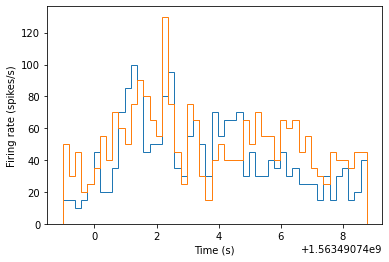

In [65]:
start_time, end_time = (SortInterval & {'nwb_file_name': nwb_file_name2}).fetch1('sort_interval')
bin_width = 0.2

import matplotlib.pyplot as plt
for i in good_cells_idx:
    plt.hist(spike_times[i], bins=np.arange(start_time, end_time, bin_width),
             histtype='step', weights = [1/bin_width]*len(spike_times[i]))
_ = plt.ylabel('Firing rate (spikes/s)')
_ = plt.xlabel('Time (s)')

Let's now get the position information for this interval

In [66]:
position_obj_id = (RawPosition & {'nwb_file_name':nwb_file_name2}).fetch1('raw_position_object_id')
raw_nwb_filepath = (Nwbfile & {'nwb_file_name':nwb_file_name2}).fetch1('nwb_file_abs_path')
with pynwb.NWBHDF5IO(raw_nwb_filepath, mode = 'r') as io:
    nwbf = io.read()
#     print(nwbf.objects[position_obj_id]['series_0'])
    # we take series 1 because it corresponds to 02_r1 interval that we used
    position = nwbf.objects[position_obj_id]['series_1'].data[:]
    t_position = nwbf.objects[position_obj_id]['series_1'].timestamps[:]

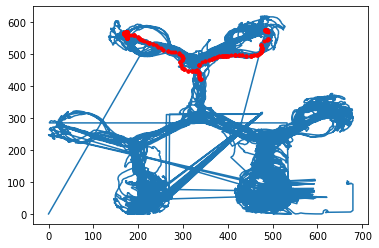

In [71]:
plt.plot(position[:,0],position[:,1])
pos_spike_idx = np.searchsorted(t_position, spike_times[good_cells_idx[0]])
plt.plot(position[pos_spike_idx,0],position[pos_spike_idx,1],'r.') 